# Import das bibliotecas

In [1]:
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC
from sklearn import datasets, neural_network, metrics
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Carrega o dataset de imagens

O dataset escolhido é um conjunto de imagens no formato JPEG de pessoas retiradas da internet. O dataset contem mais de 13.000 imagens, sendo que 1.680 possui mais de 1 foto presente no dataset. Cada imgem esta centrada em uma unica face e é composta pela descrição dos pixels como numeros float RGB entre 0 e 1.0. No dataset também esta presente uma lista com o nome de cada pessoa.

A primeira chamada do dataset é feita pegando apanas pessoas com mais de 70 fotos, ou seja, com bastante conteudo para treino e também garantindo o maximo de pixels possível.

In [2]:
people = fetch_lfw_people(min_faces_per_person=70, resize=1)

In [3]:
n_samples, height, width = people.images.shape

In [4]:
X = people.data
n_features = X.shape[1]

y = people.target
target_names = people.target_names
n_classes = target_names.shape[0]

In [5]:
print ("Numero de imagens:",n_samples,"\nPixels por imagem:",height*width)

Numero de imagens: 1288 
Pixels por imagem: 11750


# Pré processamento

Divide-se a quantidade de imagens para treinamento e para teste utilizando uma funçaõ de divisão randomica.

O atributo "test_size" da função define a porcentagem de imagens para teste.

Utiliza-se o algoritmo RandomizedPCA que faz uma redução linear dos dados, mantendo apenas os mais significativos. 

A variável "n_components" define a quantidade de elementos mantidos.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
pca = RandomizedPCA(n_components=150,whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((150, height, width))
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


Podemos plotar algumas imagens, utilizando apenas os pixels que o PCA considerou relevantes para o algoritmo.

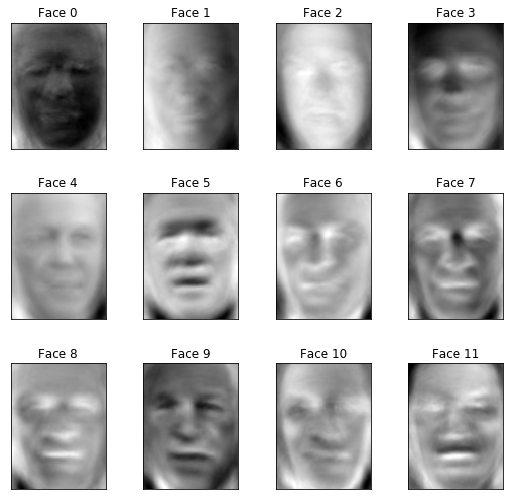

In [7]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99,
                        top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
 
eigenface_titles= []
for i in range(people.images.shape[0]):
    eigenface_titles.append("Face "+str(i))
 
plot_gallery(eigenfaces, eigenface_titles, height, width)
 
plt.show()

# SVC

## Treino 

Agora que temos nossos dados, podemos realizar o treino do algoritmo, assim como a predição. Primeira tentativa foi usando o GridSearchCV que realiza uma busca exaustiva, este por sua vez usa o SVC como estimador. 

In [8]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf'), param_grid)
clf = clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

## Avaliação

Utilizando o "classification_report" temos informações sobre os dados obtidos a partir dos dados considerados verdadeiros e os preditos. Abaixo temos dados de precisão para as fotos de cada pessoa em específico e também a média geral.

                   precision    recall  f1-score   support

     Ariel Sharon       0.93      0.70      0.80        20
     Colin Powell       0.78      0.95      0.86        41
  Donald Rumsfeld       0.76      0.76      0.76        33
    George W Bush       0.88      0.96      0.92       153
Gerhard Schroeder       1.00      0.76      0.86        25
      Hugo Chavez       1.00      0.71      0.83        17
       Tony Blair       0.92      0.73      0.81        33

      avg / total       0.88      0.87      0.87       322



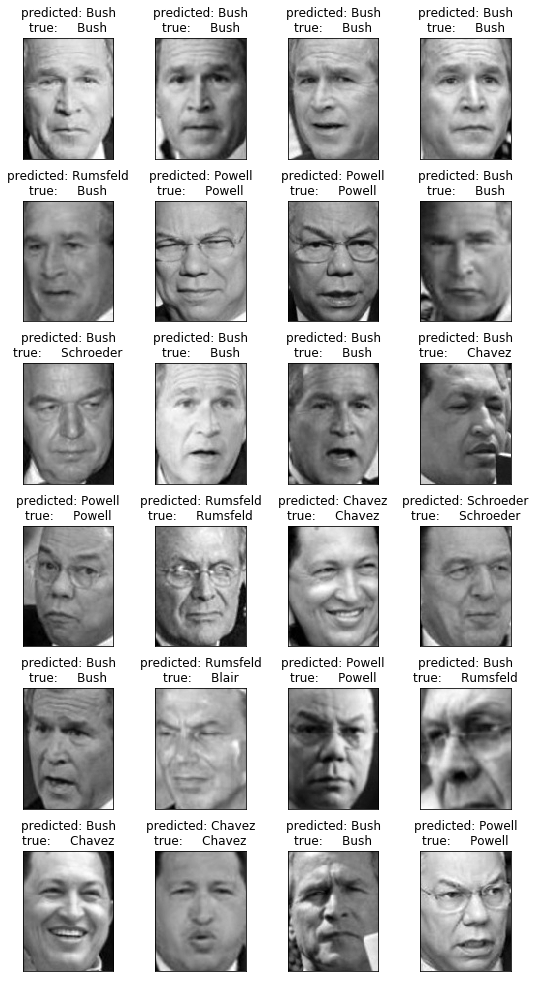

In [9]:
print(classification_report(y_test, y_pred, target_names=target_names))
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, height, width, 6, 4)
plt.show()

## Validação cruzada

In [10]:
scores = cross_val_score(clf,X_train_pca,y_train)
np.mean(scores)

0.77327438314376351

# MLPC

## 10 neuronios

In [11]:
MLPC = neural_network.MLPClassifier(hidden_layer_sizes=(10, ),
activation='relu', # {identity, logistic, tanh, relu},
solver='adam', # {lbfgs, sgd, adam},
alpha=0.0001,
learning_rate='constant', # {constant, invscaling, adaptive},
learning_rate_init=0.001,
power_t=0.5,
max_iter=1000,
shuffle=True,
tol=0.00001,
verbose=True,
momentum=0.9,
validation_fraction=0.1)

In [12]:
MLPC.fit(X_train_pca,y_train)
y_pred = MLPC.predict(X_test_pca)

Iteration 1, loss = 2.45353834
Iteration 2, loss = 2.37324539
Iteration 3, loss = 2.30395732
Iteration 4, loss = 2.23504424
Iteration 5, loss = 2.17181505
Iteration 6, loss = 2.11099439
Iteration 7, loss = 2.05403414
Iteration 8, loss = 1.99885765
Iteration 9, loss = 1.94740419
Iteration 10, loss = 1.89831965
Iteration 11, loss = 1.85111441
Iteration 12, loss = 1.80564104
Iteration 13, loss = 1.76223617
Iteration 14, loss = 1.72059089
Iteration 15, loss = 1.68089767
Iteration 16, loss = 1.64352160
Iteration 17, loss = 1.60563761
Iteration 18, loss = 1.56970229
Iteration 19, loss = 1.53514961
Iteration 20, loss = 1.50177590
Iteration 21, loss = 1.46912326
Iteration 22, loss = 1.43712148
Iteration 23, loss = 1.40685295
Iteration 24, loss = 1.37730977
Iteration 25, loss = 1.34814968
Iteration 26, loss = 1.32043917
Iteration 27, loss = 1.29307927
Iteration 28, loss = 1.26651880
Iteration 29, loss = 1.24064744
Iteration 30, loss = 1.21589413
Iteration 31, loss = 1.19103325
Iteration 32, los

Iteration 276, loss = 0.04366998
Iteration 277, loss = 0.04340279
Iteration 278, loss = 0.04314413
Iteration 279, loss = 0.04287777
Iteration 280, loss = 0.04262139
Iteration 281, loss = 0.04234900
Iteration 282, loss = 0.04210846
Iteration 283, loss = 0.04183182
Iteration 284, loss = 0.04159372
Iteration 285, loss = 0.04132979
Iteration 286, loss = 0.04108518
Iteration 287, loss = 0.04086418
Iteration 288, loss = 0.04059729
Iteration 289, loss = 0.04036722
Iteration 290, loss = 0.04013810
Iteration 291, loss = 0.03990633
Iteration 292, loss = 0.03967167
Iteration 293, loss = 0.03945186
Iteration 294, loss = 0.03921981
Iteration 295, loss = 0.03899547
Iteration 296, loss = 0.03878290
Iteration 297, loss = 0.03856814
Iteration 298, loss = 0.03836482
Iteration 299, loss = 0.03814081
Iteration 300, loss = 0.03793344
Iteration 301, loss = 0.03772751
Iteration 302, loss = 0.03752842
Iteration 303, loss = 0.03732007
Iteration 304, loss = 0.03711961
Iteration 305, loss = 0.03692695
Iteration 

Iteration 561, loss = 0.01488329
Iteration 562, loss = 0.01484593
Iteration 563, loss = 0.01481055
Iteration 564, loss = 0.01477093
Iteration 565, loss = 0.01473728
Iteration 566, loss = 0.01470184
Iteration 567, loss = 0.01466301
Iteration 568, loss = 0.01462576
Iteration 569, loss = 0.01459208
Iteration 570, loss = 0.01455321
Iteration 571, loss = 0.01452264
Iteration 572, loss = 0.01448246
Iteration 573, loss = 0.01445215
Iteration 574, loss = 0.01441449
Iteration 575, loss = 0.01438037
Iteration 576, loss = 0.01434408
Iteration 577, loss = 0.01431001
Iteration 578, loss = 0.01427899
Iteration 579, loss = 0.01424437
Iteration 580, loss = 0.01420774
Iteration 581, loss = 0.01417938
Iteration 582, loss = 0.01414555
Iteration 583, loss = 0.01410300
Iteration 584, loss = 0.01407103
Iteration 585, loss = 0.01403762
Iteration 586, loss = 0.01399948
Iteration 587, loss = 0.01396338
Iteration 588, loss = 0.01392997
Iteration 589, loss = 0.01389369
Iteration 590, loss = 0.01385726
Iteration 

Iteration 848, loss = 0.00411835
Iteration 849, loss = 0.00410649
Iteration 850, loss = 0.00409515
Iteration 851, loss = 0.00408293
Iteration 852, loss = 0.00406979
Iteration 853, loss = 0.00405843
Iteration 854, loss = 0.00404826
Iteration 855, loss = 0.00403699
Iteration 856, loss = 0.00402670
Iteration 857, loss = 0.00401449
Iteration 858, loss = 0.00400438
Iteration 859, loss = 0.00399356
Iteration 860, loss = 0.00398197
Iteration 861, loss = 0.00397043
Iteration 862, loss = 0.00395922
Iteration 863, loss = 0.00394722
Iteration 864, loss = 0.00393802
Iteration 865, loss = 0.00392658
Iteration 866, loss = 0.00391518
Iteration 867, loss = 0.00390540
Iteration 868, loss = 0.00389437
Iteration 869, loss = 0.00388331
Iteration 870, loss = 0.00387231
Iteration 871, loss = 0.00386210
Iteration 872, loss = 0.00384923
Iteration 873, loss = 0.00383920
Iteration 874, loss = 0.00382789
Iteration 875, loss = 0.00381637
Iteration 876, loss = 0.00380740
Iteration 877, loss = 0.00379577
Iteration 

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.65      0.65        20
     Colin Powell       0.59      0.88      0.71        41
  Donald Rumsfeld       0.76      0.67      0.71        33
    George W Bush       0.89      0.84      0.87       153
Gerhard Schroeder       0.70      0.64      0.67        25
      Hugo Chavez       0.72      0.76      0.74        17
       Tony Blair       0.77      0.61      0.68        33

      avg / total       0.79      0.77      0.77       322



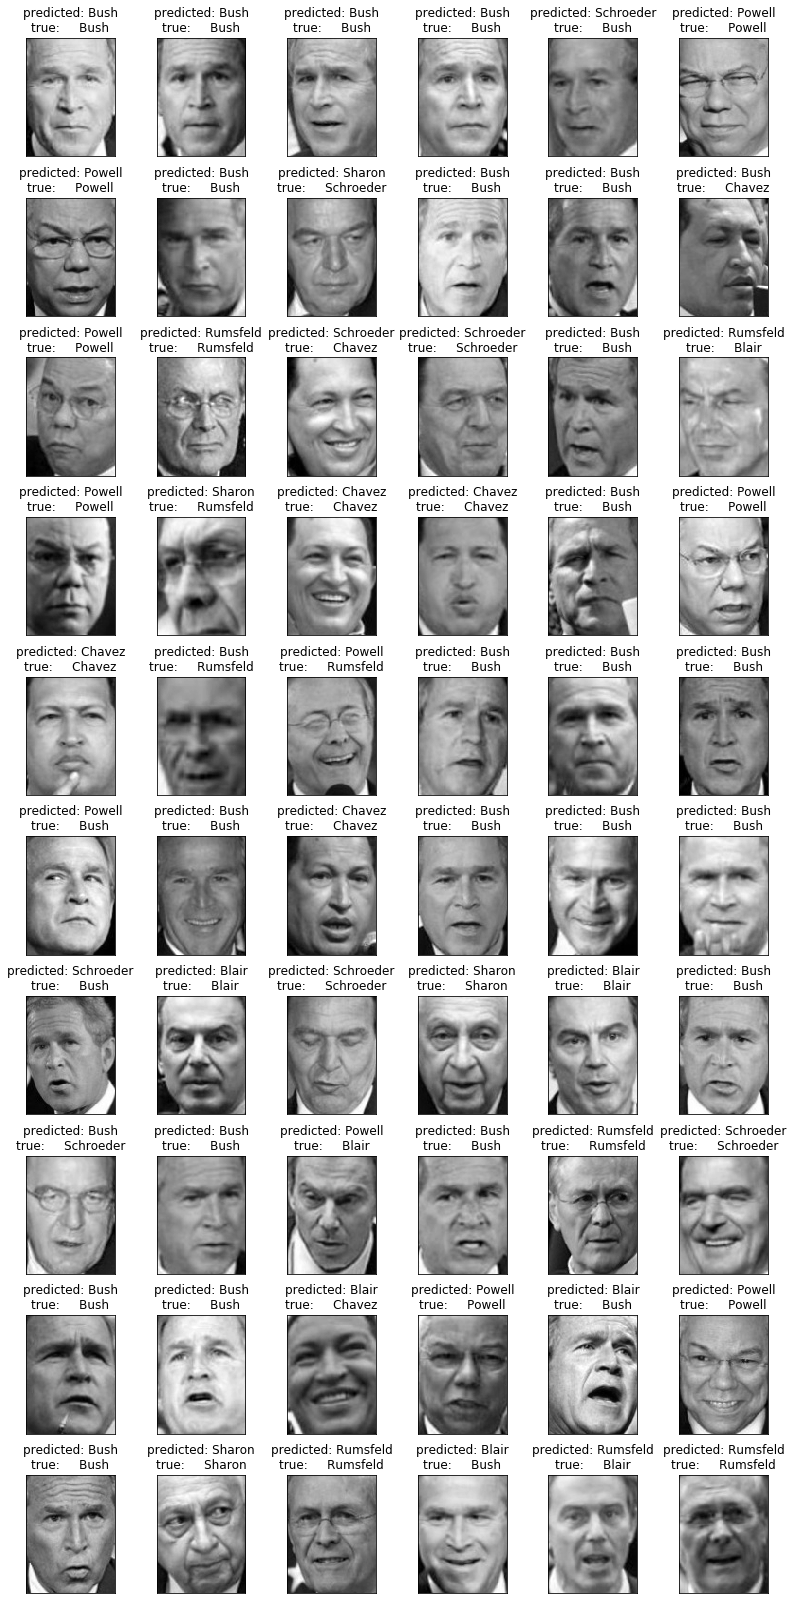

In [13]:
print(classification_report(y_test, y_pred, target_names=target_names))

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
    
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, height, width ,10, 6)
plt.show()


In [ ]:
scores = cross_val_score(MLPC,X_train_pca,y_train)

In [15]:
np.mean(scores)

0.71223597831812924

## 10000 neuronios

Iteration 1, loss = 1.52841389
Iteration 2, loss = 0.45458471
Iteration 3, loss = 0.16965885
Iteration 4, loss = 0.06698734
Iteration 5, loss = 0.03236624
Iteration 6, loss = 0.01721105
Iteration 7, loss = 0.01086476
Iteration 8, loss = 0.00777914
Iteration 9, loss = 0.00591225
Iteration 10, loss = 0.00479928
Iteration 11, loss = 0.00411254
Iteration 12, loss = 0.00362579
Iteration 13, loss = 0.00328117
Iteration 14, loss = 0.00300637
Iteration 15, loss = 0.00278401
Iteration 16, loss = 0.00260365
Iteration 17, loss = 0.00244265
Iteration 18, loss = 0.00230827
Iteration 19, loss = 0.00218472
Iteration 20, loss = 0.00207363
Iteration 21, loss = 0.00197408
Iteration 22, loss = 0.00188212
Iteration 23, loss = 0.00179857
Iteration 24, loss = 0.00172201
Iteration 25, loss = 0.00165012
Iteration 26, loss = 0.00158220
Iteration 27, loss = 0.00151985
Iteration 28, loss = 0.00146264
Iteration 29, loss = 0.00140612
Iteration 30, loss = 0.00135587
Iteration 31, loss = 0.00130701
Iteration 32, los

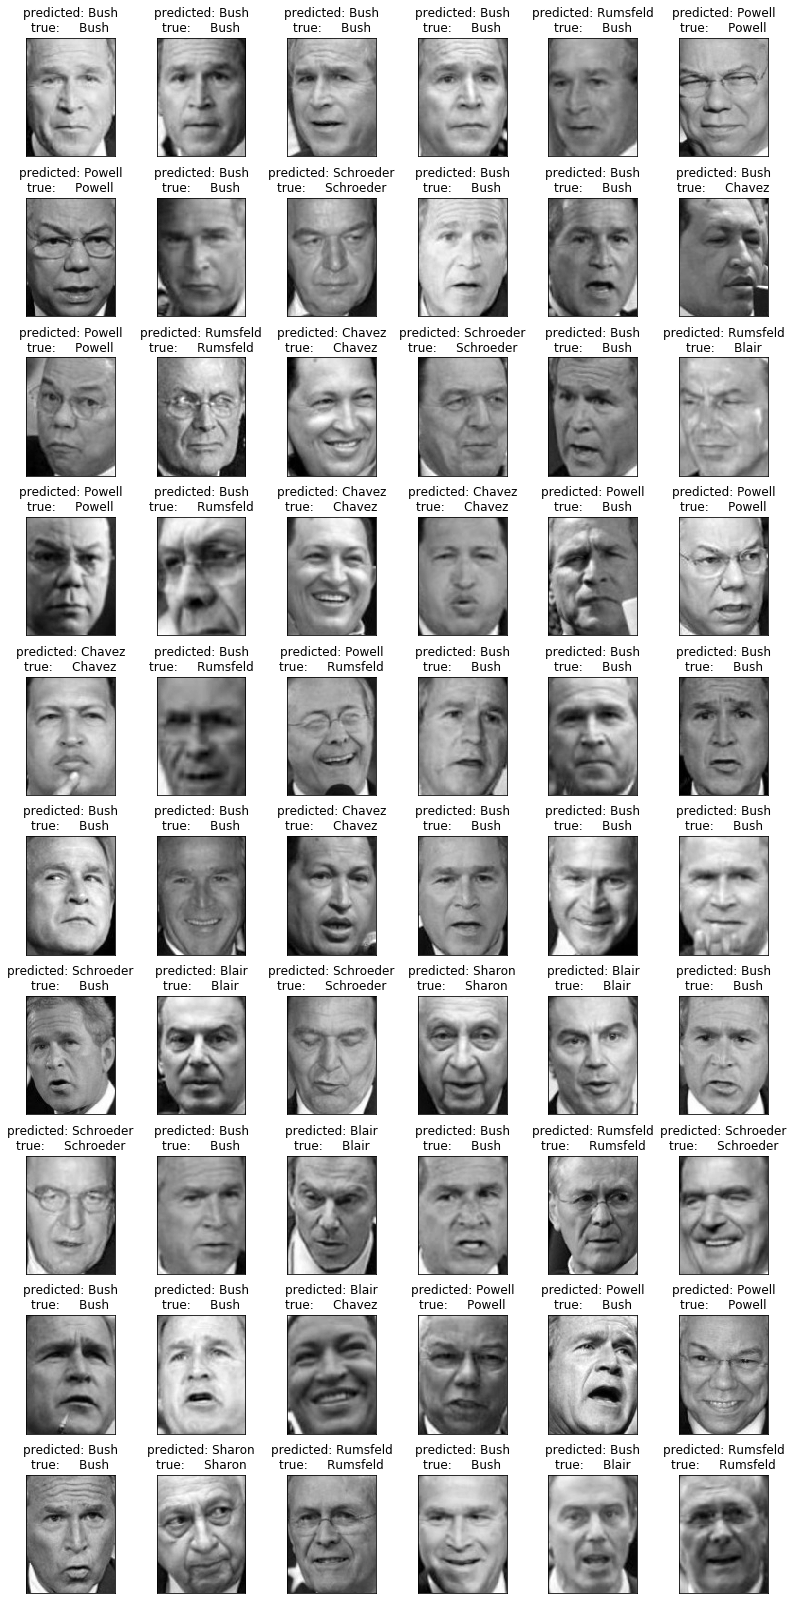

In [16]:
MLPC = neural_network.MLPClassifier(hidden_layer_sizes=(10000,),
activation='relu', # {identity, logistic, tanh, relu},
solver='adam', # {lbfgs, sgd, adam},
alpha=0.0001,
learning_rate='constant', # {constant, invscaling, adaptive},
learning_rate_init=0.001,
power_t=0.5,
max_iter=1000,
shuffle=True,
tol=0.00001,
verbose=True,
momentum=0.9,
validation_fraction=0.1)


MLPC.fit(X_train_pca,y_train)
y_pred = MLPC.predict(X_test_pca)


print(classification_report(y_test, y_pred, target_names=target_names))
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, height, width ,10, 6)
plt.show()

In [ ]:
scores = cross_val_score(MLPC,X_train_pca,y_train)

In [18]:
np.mean(scores)

0.7878058357085358

## 10000 neuronios e tolerancia aumentada 100x

Iteration 1, loss = 1.55138791
Iteration 2, loss = 0.48529361
Iteration 3, loss = 0.18003310
Iteration 4, loss = 0.08116690
Iteration 5, loss = 0.03801619
Iteration 6, loss = 0.01964623
Iteration 7, loss = 0.01301515
Iteration 8, loss = 0.00966111
Iteration 9, loss = 0.00731898
Iteration 10, loss = 0.00577863
Iteration 11, loss = 0.00481474
Iteration 12, loss = 0.00420881
Iteration 13, loss = 0.00378368
Iteration 14, loss = 0.00346133
Iteration 15, loss = 0.00320100
Iteration 16, loss = 0.00298007
Iteration 17, loss = 0.00279568
Iteration 18, loss = 0.00263092
Iteration 19, loss = 0.00248603
Iteration 20, loss = 0.00236340
Iteration 21, loss = 0.00224499
Iteration 22, loss = 0.00213865
Iteration 23, loss = 0.00204280
Iteration 24, loss = 0.00195273
Iteration 25, loss = 0.00186951
Iteration 26, loss = 0.00179201
Iteration 27, loss = 0.00171892
Iteration 28, loss = 0.00165215
Iteration 29, loss = 0.00159006
Iteration 30, loss = 0.00152924
Iteration 31, loss = 0.00147422
Iteration 32, los

Iteration 253, loss = 0.00019086
Iteration 254, loss = 0.00019052
Iteration 255, loss = 0.00019020
Iteration 256, loss = 0.00018986
Iteration 257, loss = 0.00018954
Iteration 258, loss = 0.00018921
Iteration 259, loss = 0.00018889
Iteration 260, loss = 0.00018858
Iteration 261, loss = 0.00018826
Iteration 262, loss = 0.00018796
Iteration 263, loss = 0.00018765
Iteration 264, loss = 0.00018734
Iteration 265, loss = 0.00018704
Iteration 266, loss = 0.00018675
Iteration 267, loss = 0.00018645
Iteration 268, loss = 0.00018616
Iteration 269, loss = 0.00018587
Iteration 270, loss = 0.00018559
Iteration 271, loss = 0.00018530
Iteration 272, loss = 0.00018502
Iteration 273, loss = 0.00018475
Iteration 274, loss = 0.00018447
Iteration 275, loss = 0.00018420
Iteration 276, loss = 0.00018394
Iteration 277, loss = 0.00018367
Iteration 278, loss = 0.00018340
Iteration 279, loss = 0.00018314
Iteration 280, loss = 0.00018288
Iteration 281, loss = 0.00018263
Iteration 282, loss = 0.00018237
Iteration 

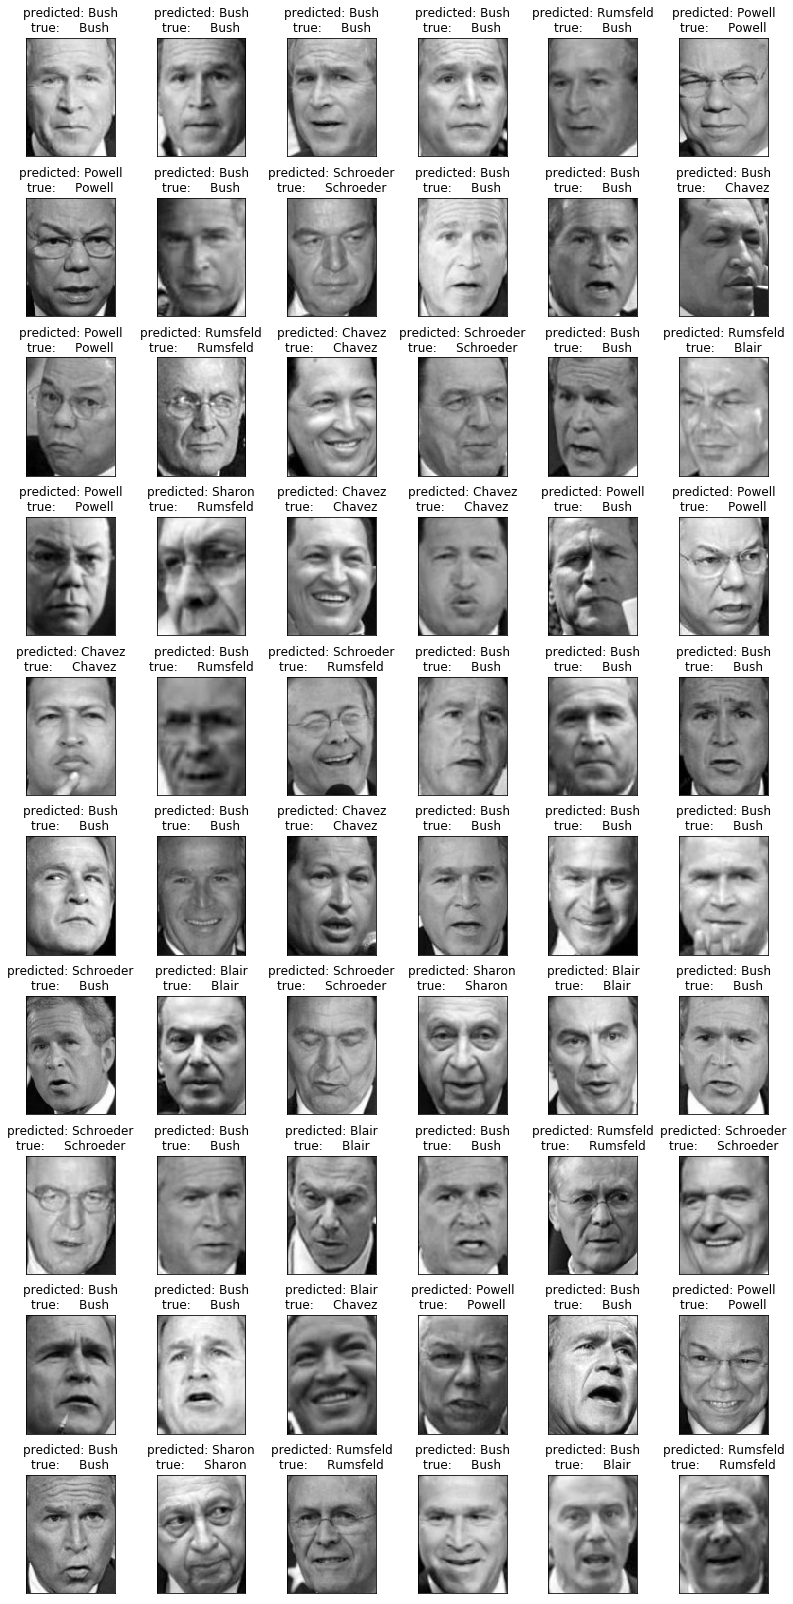

In [19]:
MLPC = neural_network.MLPClassifier(hidden_layer_sizes=(10000, ),
activation='relu', # {identity, logistic, tanh, relu},
solver='adam', # {lbfgs, sgd, adam},
alpha=0.0001,
learning_rate='constant', # {constant, invscaling, adaptive},
learning_rate_init=0.001,
power_t=0.5,
max_iter=1000,
shuffle=True,
tol=0.0000001,
verbose=True,
momentum=0.9,
validation_fraction=0.1)


MLPC.fit(X_train_pca,y_train)
y_pred = MLPC.predict(X_test_pca)


print(classification_report(y_test, y_pred, target_names=target_names))
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, height, width ,10, 6)
plt.show()

In [ ]:
scores = cross_val_score(MLPC,X_train_pca,y_train)

In [21]:
np.mean(scores)

0.796087469112983

## Sem pre-processamento

Iteration 1, loss = 18.80968145
Iteration 2, loss = 17.09359111
Iteration 3, loss = 16.99832847
Iteration 4, loss = 19.23977620
Iteration 5, loss = 16.71816824
Iteration 6, loss = 19.19532703
Iteration 7, loss = 14.19025530
Iteration 8, loss = 17.13692050
Iteration 9, loss = 16.55970830
Iteration 10, loss = 14.92883587
Training loss did not improve more than tol=0.000010 for two consecutive epochs. Stopping.


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        20
     Colin Powell       0.56      0.54      0.55        41
  Donald Rumsfeld       0.00      0.00      0.00        33
    George W Bush       0.77      0.82      0.79       153
Gerhard Schroeder       0.00      0.00      0.00        25
      Hugo Chavez       0.00      0.00      0.00        17
       Tony Blair       0.23      0.82      0.36        33

      avg / total       0.46      0.54      0.48       322



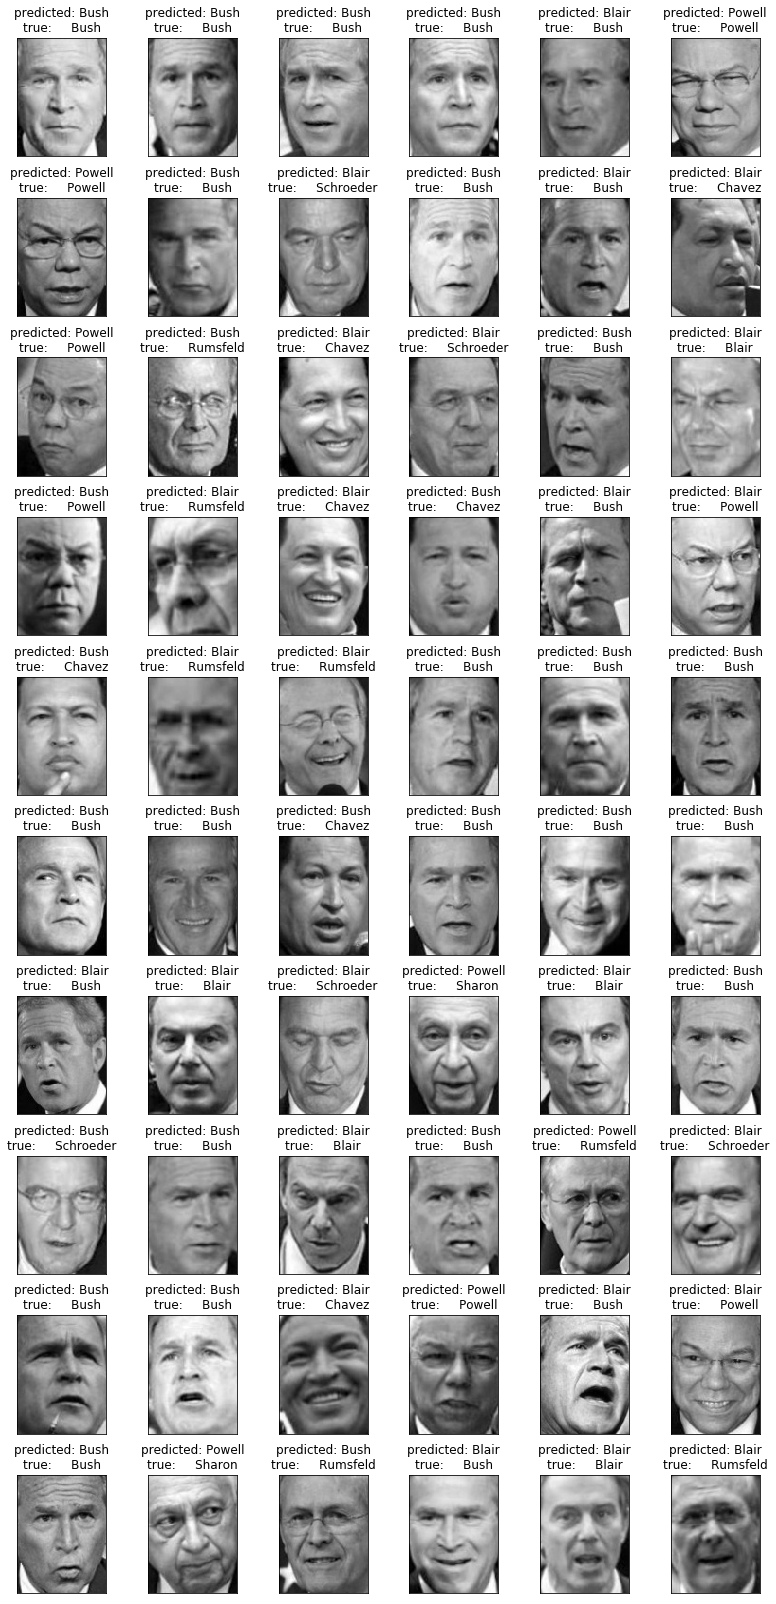

In [22]:
MLPC = neural_network.MLPClassifier(hidden_layer_sizes=(10000, ),
activation='relu', # {identity, logistic, tanh, relu},
solver='adam', # {lbfgs, sgd, adam},
alpha=0.0001,
learning_rate='constant', # {constant, invscaling, adaptive},
learning_rate_init=0.001,
power_t=0.5,
max_iter=1000,
shuffle=True,
tol=0.00001,
verbose=True,
momentum=0.9,
validation_fraction=0.1)


MLPC.fit(X_train,y_train)
y_pred = MLPC.predict(X_test)


print(classification_report(y_test, y_pred, target_names=target_names))
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, height, width ,10, 6)
plt.show()

In [ ]:
scores = cross_val_score(MLPC,X_train,y_train)

In [24]:
np.mean(scores)

0.35703895108375905

## Com 4x componentes no pre processamento

Anteriormente foram mantidos 150 componentes pelo PCA no pre processamento. Este sera refeito com o dobro de componentes para ver como afeta o resultado.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
pca = RandomizedPCA(n_components=600,whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((600, height, width))
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


Iteration 1, loss = 1.86157225
Iteration 2, loss = 0.16475111
Iteration 3, loss = 0.01158932
Iteration 4, loss = 0.00321824
Iteration 5, loss = 0.00211562
Iteration 6, loss = 0.00163740
Iteration 7, loss = 0.00134109
Iteration 8, loss = 0.00109637
Iteration 9, loss = 0.00096137
Iteration 10, loss = 0.00084478
Iteration 11, loss = 0.00077325
Iteration 12, loss = 0.00072244
Iteration 13, loss = 0.00068288
Iteration 14, loss = 0.00065344
Iteration 15, loss = 0.00062982
Iteration 16, loss = 0.00061066
Iteration 17, loss = 0.00059576
Iteration 18, loss = 0.00058281
Iteration 19, loss = 0.00057140
Iteration 20, loss = 0.00056168
Iteration 21, loss = 0.00055296
Iteration 22, loss = 0.00054488
Training loss did not improve more than tol=0.000010 for two consecutive epochs. Stopping.
                   precision    recall  f1-score   support

     Ariel Sharon       0.45      0.64      0.53        14
     Colin Powell       0.75      0.52      0.61        58
  Donald Rumsfeld       0.75      0.

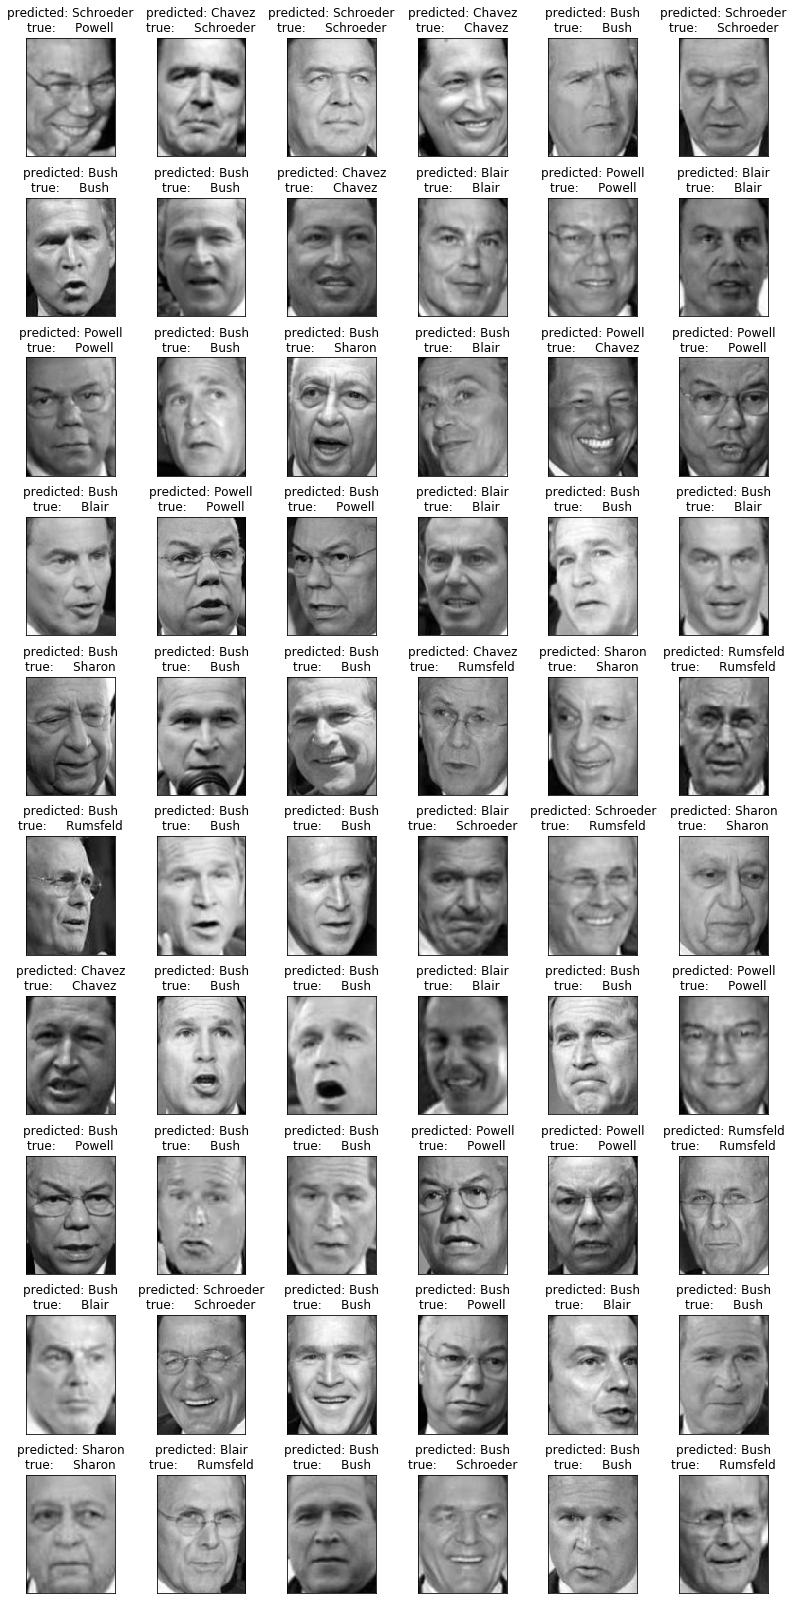

In [26]:
MLPC = neural_network.MLPClassifier(hidden_layer_sizes=(10000, ),
activation='relu', # {identity, logistic, tanh, relu},
solver='adam', # {lbfgs, sgd, adam},
alpha=0.0001,
learning_rate='constant', # {constant, invscaling, adaptive},
learning_rate_init=0.001,
power_t=0.5,
max_iter=1000,
shuffle=True,
tol=0.00001,
verbose=True,
momentum=0.9,
validation_fraction=0.1)


MLPC.fit(X_train_pca,y_train)
y_pred = MLPC.predict(X_test_pca)


print(classification_report(y_test, y_pred, target_names=target_names))
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, height, width ,10, 6)
plt.show()

In [ ]:
scores = cross_val_score(MLPC,X_train_pca,y_train)

In [28]:
np.mean(scores)

0.42557133157600441

## Recarregar o dataset permitindo pessoas com menor quantidade de imagens

In [29]:
people = fetch_lfw_people(min_faces_per_person=10, resize=1)

In [30]:
n_samples, height, width = people.images.shape

X = people.data
n_features = X.shape[1]

y = people.target
target_names = people.target_names
n_classes = target_names.shape[0]
print ("Numero de imagens:",n_samples,"\nPixels por imagem:",height*width)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
pca = RandomizedPCA(n_components=150,whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((150, height, width))
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Numero de imagens: 4324 
Pixels por imagem: 11750


/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


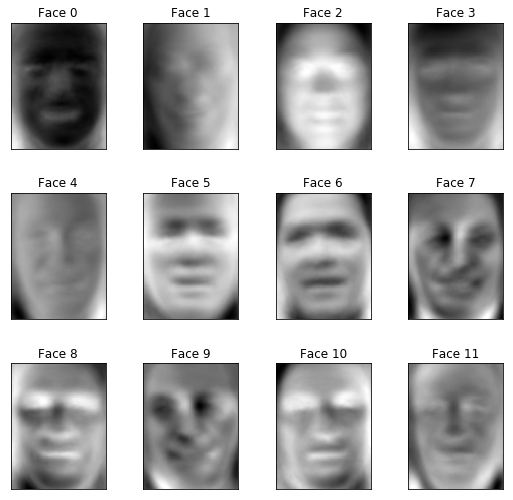

In [31]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99,
                        top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
 
eigenface_titles= []
for i in range(people.images.shape[0]):
    eigenface_titles.append("Face "+str(i))
 
plot_gallery(eigenfaces, eigenface_titles, height, width)
 
plt.show()

Iteration 1, loss = 4.23171642
Iteration 2, loss = 1.70764434
Iteration 3, loss = 0.62814414
Iteration 4, loss = 0.22588197
Iteration 5, loss = 0.09163173
Iteration 6, loss = 0.04904343
Iteration 7, loss = 0.03174018
Iteration 8, loss = 0.02350803
Iteration 9, loss = 0.01863166
Iteration 10, loss = 0.01537030
Iteration 11, loss = 0.01304615
Iteration 12, loss = 0.01132130
Iteration 13, loss = 0.00991228
Iteration 14, loss = 0.00880117
Iteration 15, loss = 0.00788142
Iteration 16, loss = 0.00712761
Iteration 17, loss = 0.00647290
Iteration 18, loss = 0.00592697
Iteration 19, loss = 0.00546385
Iteration 20, loss = 0.00505656
Iteration 21, loss = 0.00469168
Iteration 22, loss = 0.00438428
Iteration 23, loss = 0.00410050
Iteration 24, loss = 0.00385746
Iteration 25, loss = 0.00362822
Iteration 26, loss = 0.00343027
Iteration 27, loss = 0.00325513
Iteration 28, loss = 0.00308935
Iteration 29, loss = 0.00294613
Iteration 30, loss = 0.00280804
Iteration 31, loss = 0.00268708
Iteration 32, los

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 157, does not match size of target_names, 158
  .format(len(labels), len(target_names))
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                           precision    recall  f1-score   support

             Abdullah Gul       0.33      0.50      0.40         2
             Adrien Brody       0.33      0.50      0.40         2
         Alejandro Toledo       0.62      0.67      0.64        12
             Alvaro Uribe       0.56      0.71      0.63         7
          Amelie Mauresmo       0.67      0.67      0.67         3
             Andre Agassi       0.44      0.40      0.42        10
             Andy Roddick       0.00      0.00      0.00         1
           Angelina Jolie       0.33      0.20      0.25         5
              Ann Veneman       0.00      0.00      0.00         3
          Anna Kournikova       0.00      0.00      0.00         4
            Ari Fleischer       1.00      0.50      0.67         2
             Ariel Sharon       0.36      0.82      0.50        11
    Arnold Schwarzenegger       0.13      0.17      0.15        12
     Atal Bihari Vajpayee       1.00      0.57      0.73     

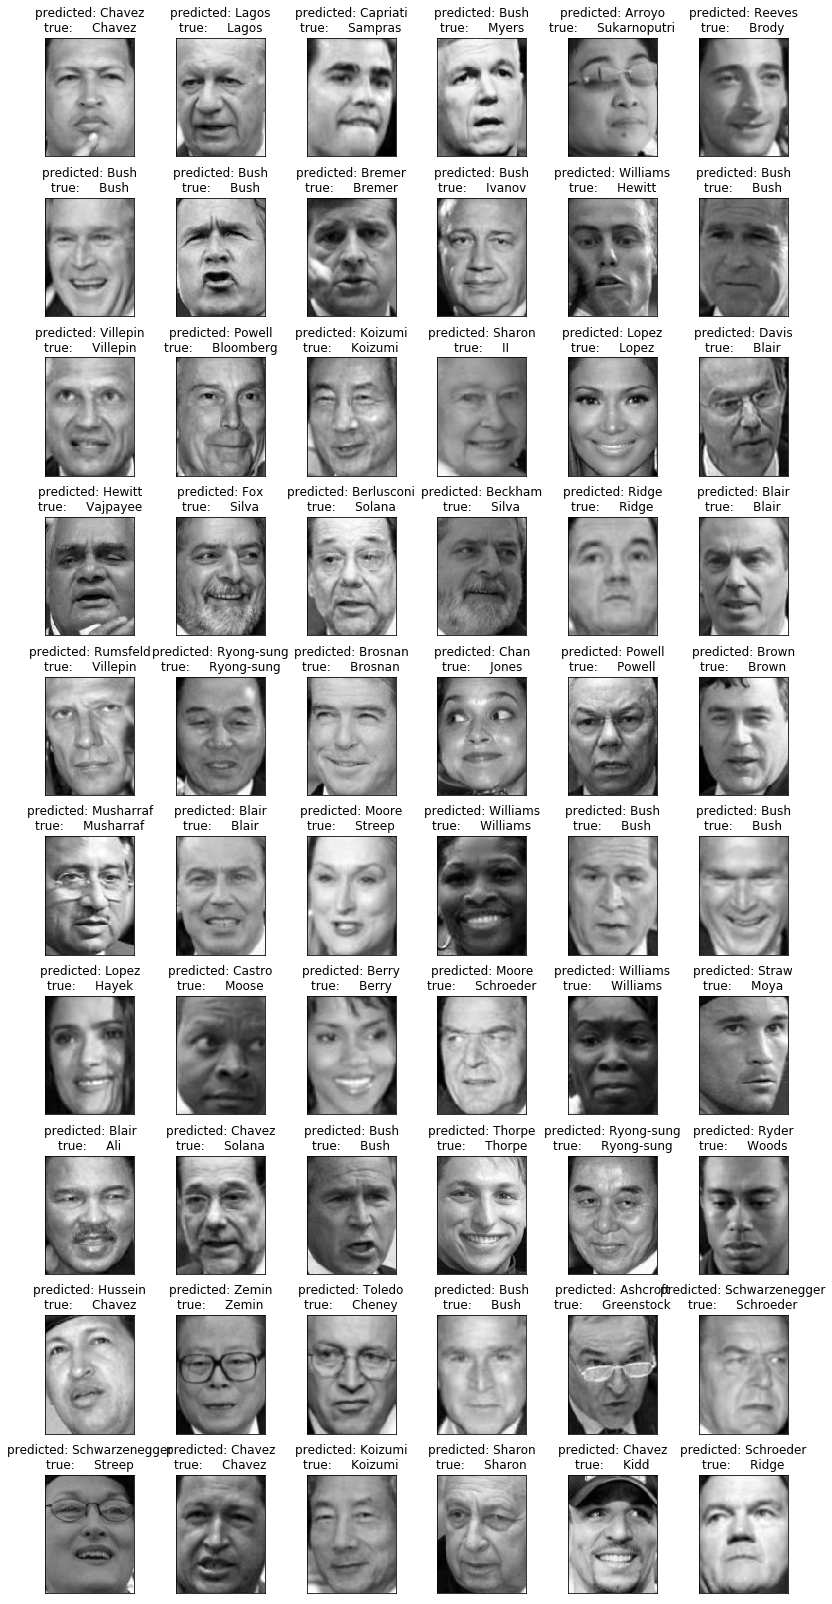

In [32]:
MLPC = neural_network.MLPClassifier(hidden_layer_sizes=(10000, ),
activation='relu', # {identity, logistic, tanh, relu},
solver='adam', # {lbfgs, sgd, adam},
alpha=0.0001,
learning_rate='constant', # {constant, invscaling, adaptive},
learning_rate_init=0.001,
power_t=0.5,
max_iter=1000,
shuffle=True,
tol=0.00001,
verbose=True,
momentum=0.9,
validation_fraction=0.1)


MLPC.fit(X_train_pca,y_train)
y_pred = MLPC.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, height, width ,10, 6)
plt.show()

In [ ]:
scores = cross_val_score(MLPC,X_train_pca,y_train)

In [34]:
np.mean(scores)

0.46902854860637172